In [1]:
# import snake, numpy, gym and pygame
from env import *
import tqdm

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
env = SnakeEnv(
    render_mode=None,
    width=15,
    height=15,
    periodic=False,
    food_reward=1,
    terminated_penalty=-1
)

In [3]:
# REPLAY MEMORY
# this is where we store the (s,a,s',r) transitions in order to randomly sample them in the training steps
# this is to avoid highly correlated updates (look up experience replay buffer)

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()

        # a first layer with narrow filters to identify walls, corners, dead ends...
        # returns (w-2)x(h-2) when padding is 'valid'
        self.cnn_layer1 = nn.Conv2d(
            in_channels=1,
            out_channels=15, # this determines the number of filters: if one filter, only one output plane...
            kernel_size=3,
            # stride=1,
            padding='valid',
            # dilation=1, #this expands the filter without augmenting the parameters... to identify spatially large patterns with less parameters
            # groups=1, # determines the connection between input channels and output channels
            # bias=True
            # padding_mode='circular' # revert to default which is zeroes... circular breaks it
        )
        
        self.cnn_activation1 = nn.ReLU()
        
        # a larger kernel size to identify bigger configurations of smaller patterns?
        # since we are at a 13x13 screen, maybe do a 5x5 kernel
        self.cnn_layer2 = nn.Conv2d(
            in_channels=15,
            out_channels=15,
            kernel_size=7,
            stride=4,
            padding='valid'
        )

        self.cnn_activation2 = nn.ReLU()

        self.cnn_layer3 = nn.Conv2d(
                in_channels=15,
                out_channels=15,
                kernel_size=2,
                padding='valid',
                bias=True
            )
        
        self.cnn_activation3 = nn.ReLU()

        # now we join the two features: the result of the various convolutions (which is, one flattened, 15 features)
        # and the one hot encoded direction information (4 neurons)

        self.fnn_layer1 = nn.Linear(
            15+4,
            20
        )

        self.fnn_activation1 = nn.ReLU()

        # final layer
        self.fnn_layer2= nn.Linear(
            20,
            4
        )

        self.fnn_activation2 = nn.Softmax(dim=0)


    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, input_dict : dict):

        x = self.cnn_activation1(self.cnn_layer1(torch.Tensor(input_dict['screen']).reshape(-1,1,15,15)))
        x = self.cnn_activation2(self.cnn_layer2(x))
        x = self.cnn_activation3(self.cnn_layer3(x))
        y = torch.Tensor(input_dict['direction'])
        z = torch.cat((x[:,:,0,0],y.reshape(-1,4)),dim=1)
        z = self.fnn_activation1(self.fnn_layer1(z))
        z = self.fnn_activation2(self.fnn_layer2(z))
        return z

In [5]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

state,_ = env.reset()


policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

In [6]:
def select_action(state):
    state_reshaped = {
        'screen' : state['screen'].reshape(1,15,15),
        'direction' : state['direction'].reshape(1,4)
    }
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state_reshaped).argmax(-1).reshape(1,-1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)


    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))



    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    # non_final_next_states = torch.cat([s for s in batch.next_state
                                                # if s is not None])
    non_final_next_states = {
        'screen' : torch.Tensor(np.array([s['screen'] for s in batch.next_state if s is not None])),
        'direction' : torch.Tensor(np.array([s['direction'] for s in batch.next_state if s is not None]))
    }
    # non_final_next_states['screen'] is a batch of observations fro the screen...
    # state_batch = torch.cat(batch.state)
    screen_batch = torch.Tensor(np.array([state['screen'] for state in batch.state]))
    direction_batch = torch.Tensor((np.array([state['direction'] for state in batch.state])))
    obs_batch = {'screen':screen_batch,'direction':direction_batch}
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(obs_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).argmax()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

100%|██████████| 500/500 [00:31<00:00, 15.76it/s]

Complete


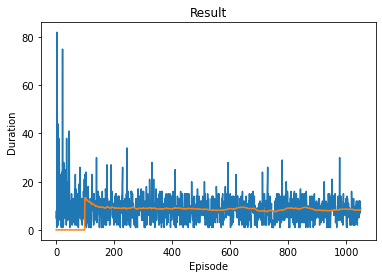

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [12]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 500

for i_episode in tqdm.trange(num_episodes):
    # Initialize the environment and get it's state
    state,_=env.reset()

    for t in count():
        action = select_action(state)
        observation, reward, terminated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = observation

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            # plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [13]:
torch.save(policy_net,'policy_net.pth')
torch.save(target_net,'target_net.pth')
